In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2

columns = ["age", "job", "marital", "education", "default", "balance", "housing", "loan",
           "contact", "day", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]

data = pd.read_csv("bank-full.csv", delimiter=";", names=columns, skiprows=1)

data['y'] = data['y'].map({'no': 0, 'yes': 1})

numeric_features = data.select_dtypes(include=[np.number]).columns.values.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print(data.head())
print(data.describe())
print(data.info())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  y  
0  unknown    5   may       261         1     -1         0  unknown  0  
1  unknown    5   may       151         1     -1         0  unknown  0  
2  unknown    5   may        76         1     -1         0  unknown  0  
3  unknown    5   may        92         1     -1         0  unknown  0  
4  unknown    5   may       198         1     -1         0  unknown  0  
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  4

In [2]:
print(data.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


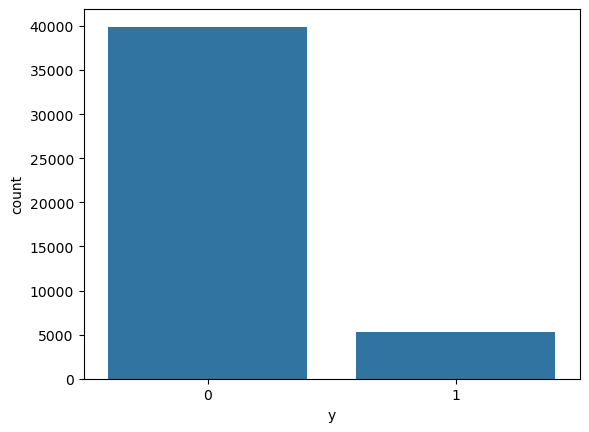

In [3]:
sns.countplot(x='y', data=data)
plt.show()

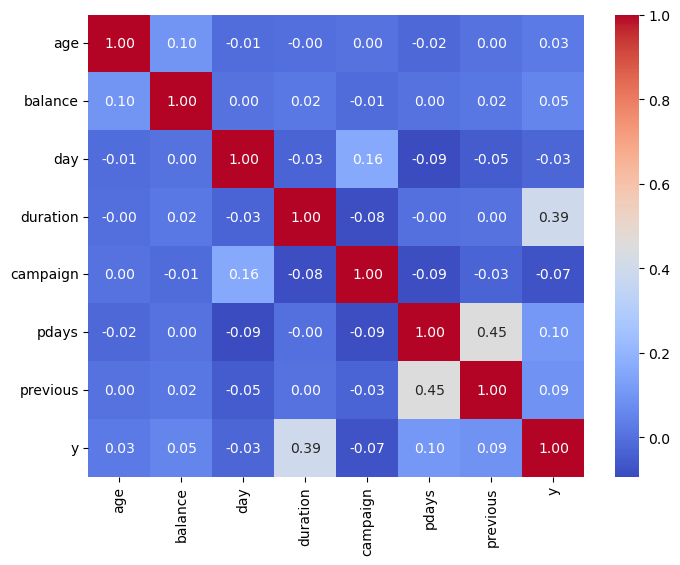

In [4]:
# Visualize the correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

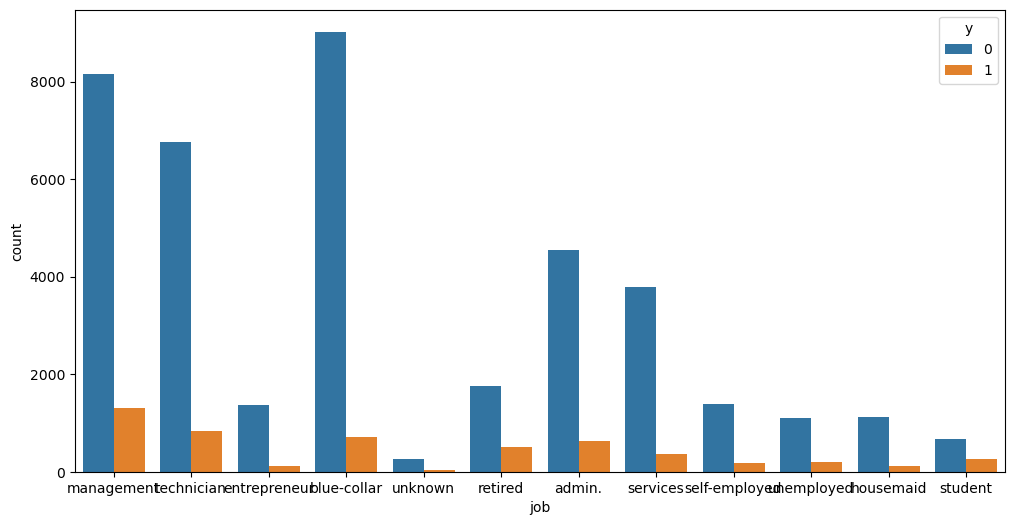

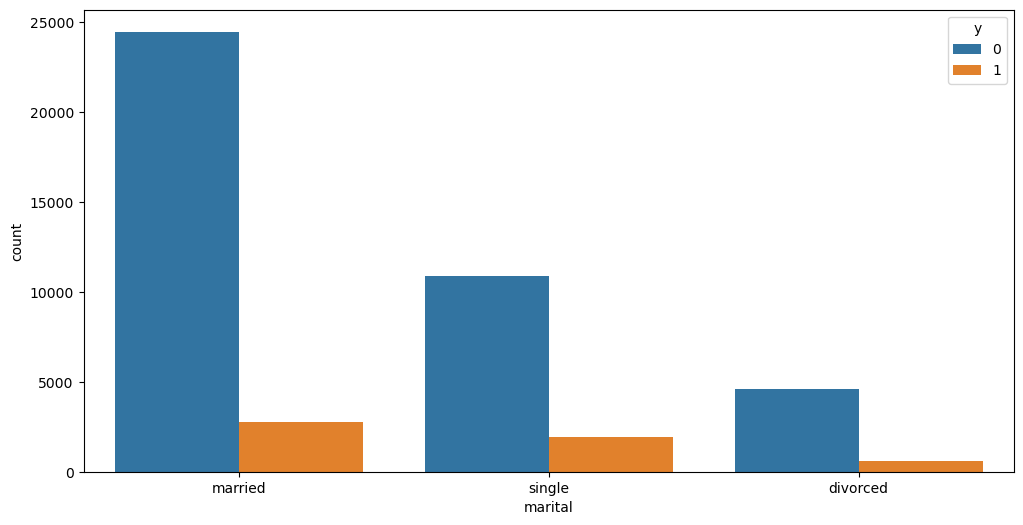

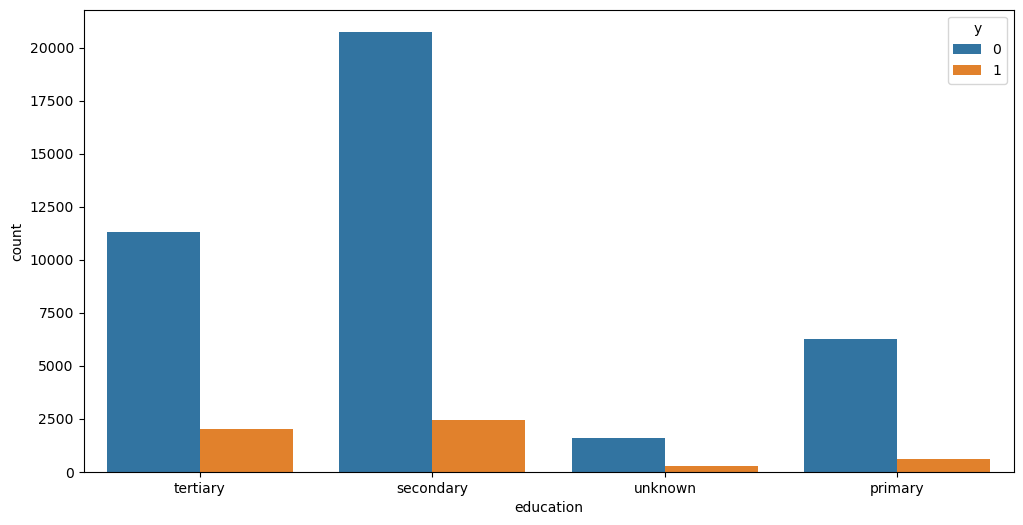

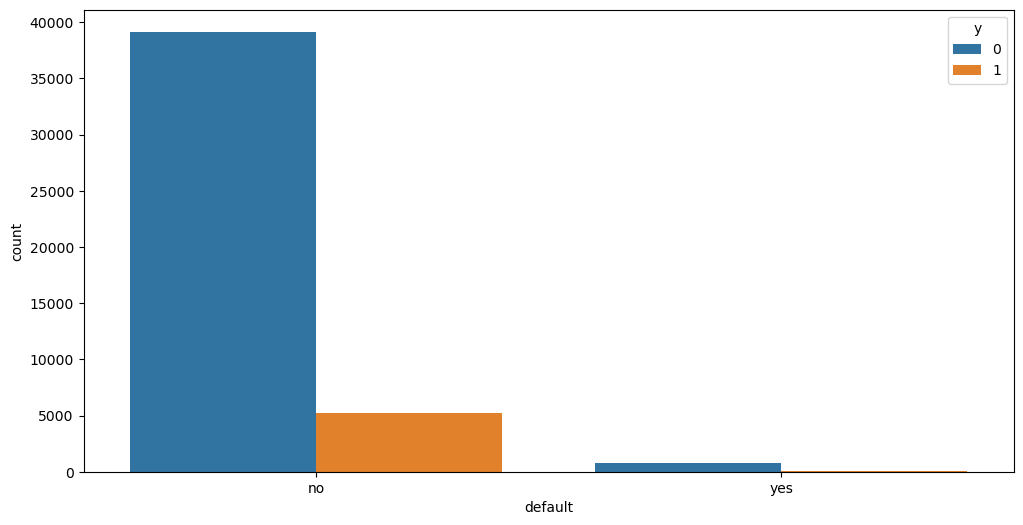

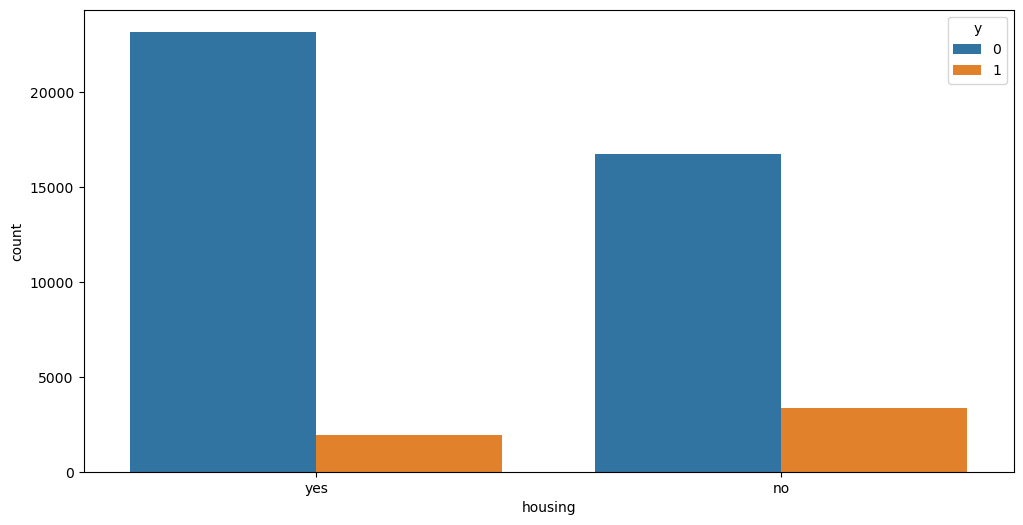

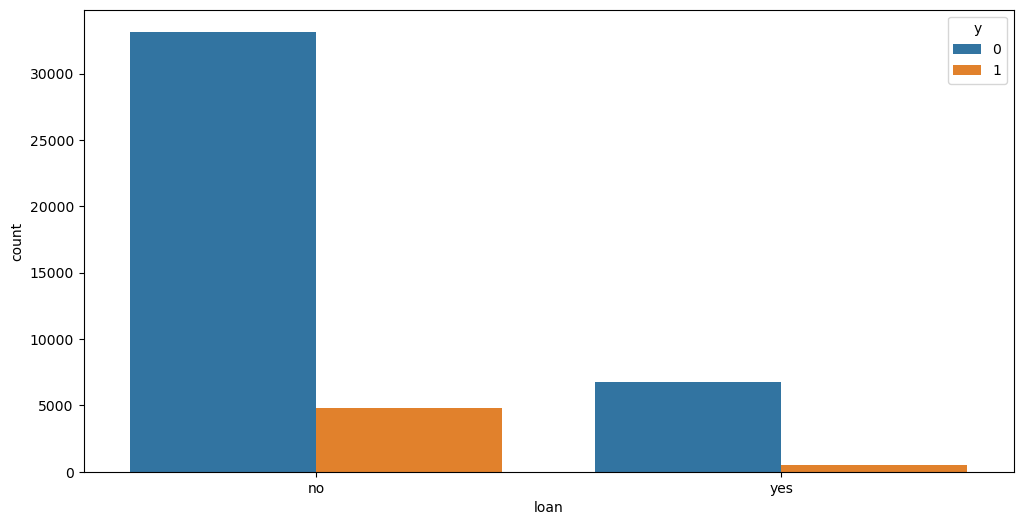

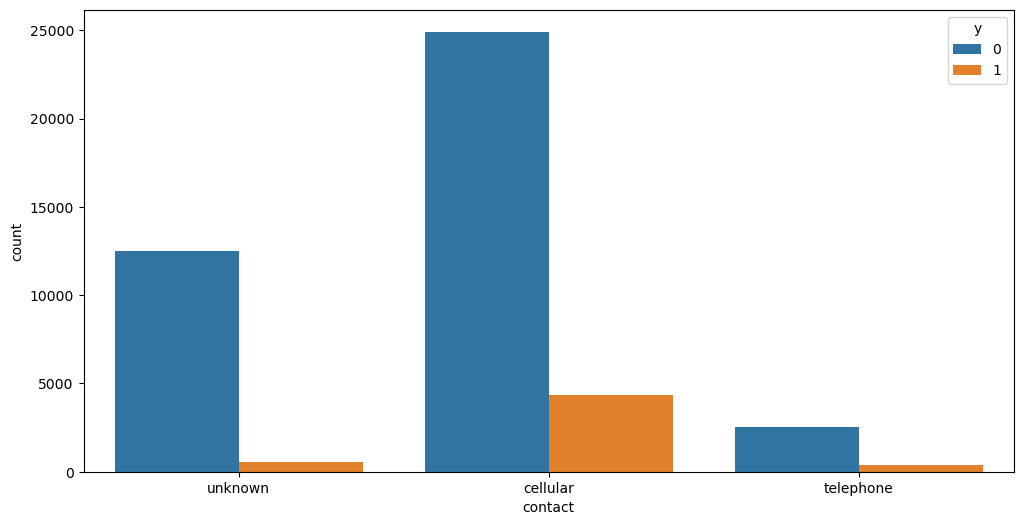

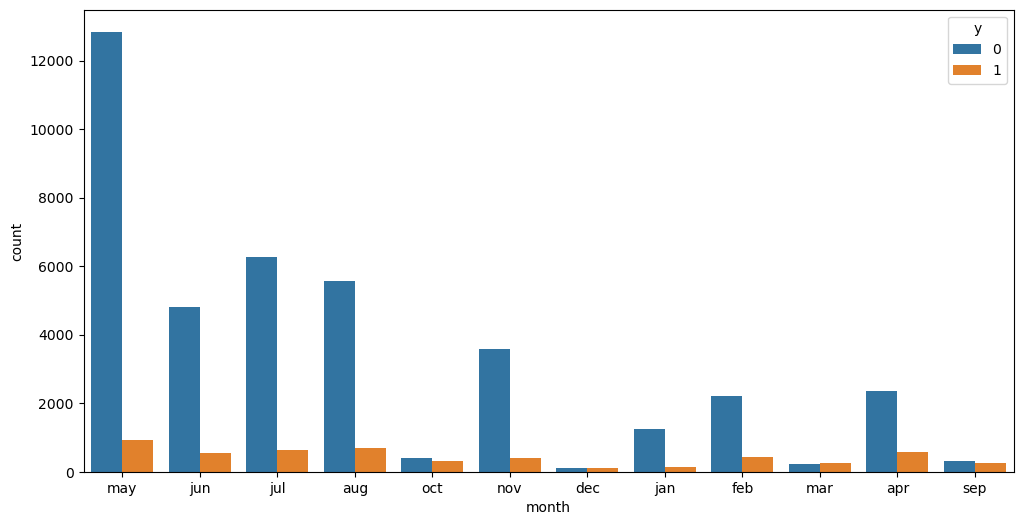

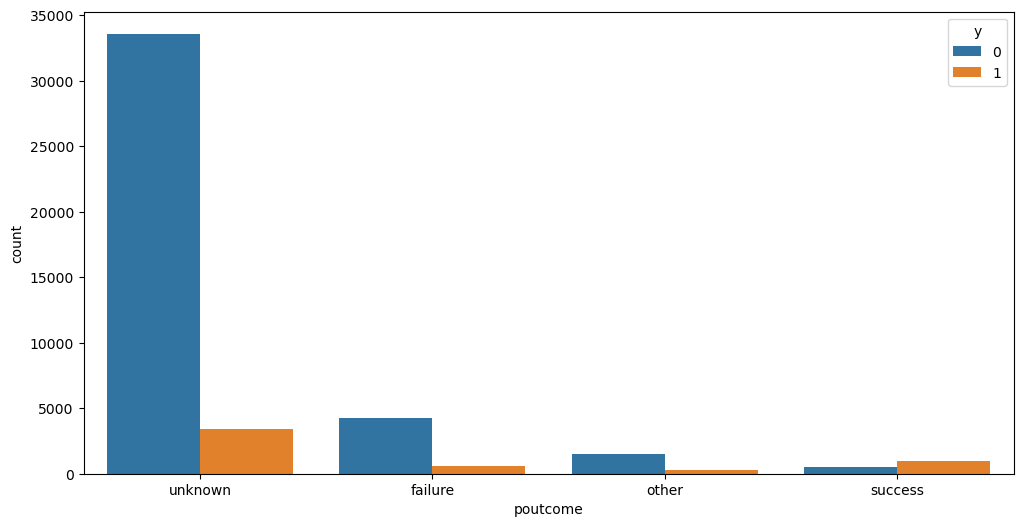

In [5]:
# Visualize categorical variables

for col in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=col, hue='y', data=data)
    plt.show()

In [6]:
# Feature engineering and preprocessing
X = data.drop('y', axis=1)
y = pd.DataFrame(data['y'])

numeric_features.remove("y")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

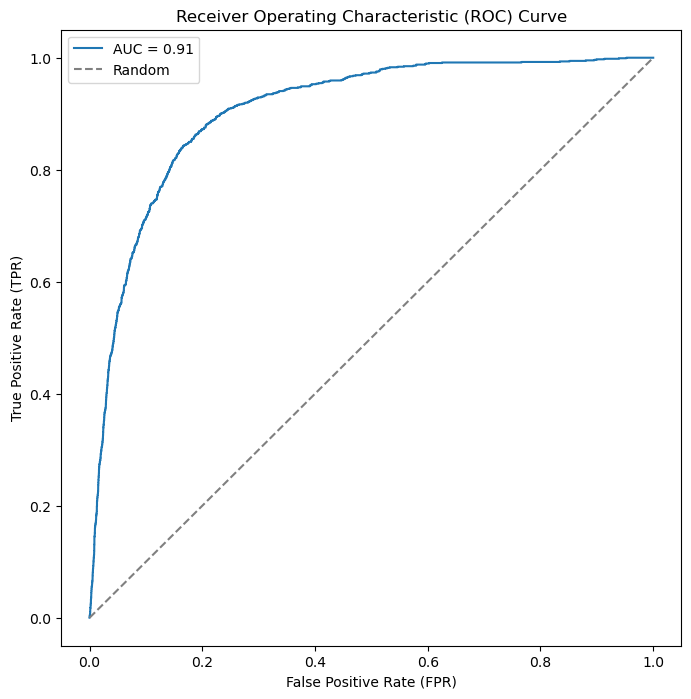


Model: Basic Logistic Regression
Confusion Matrix:
 [[7783  202]
 [ 689  369]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.65      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



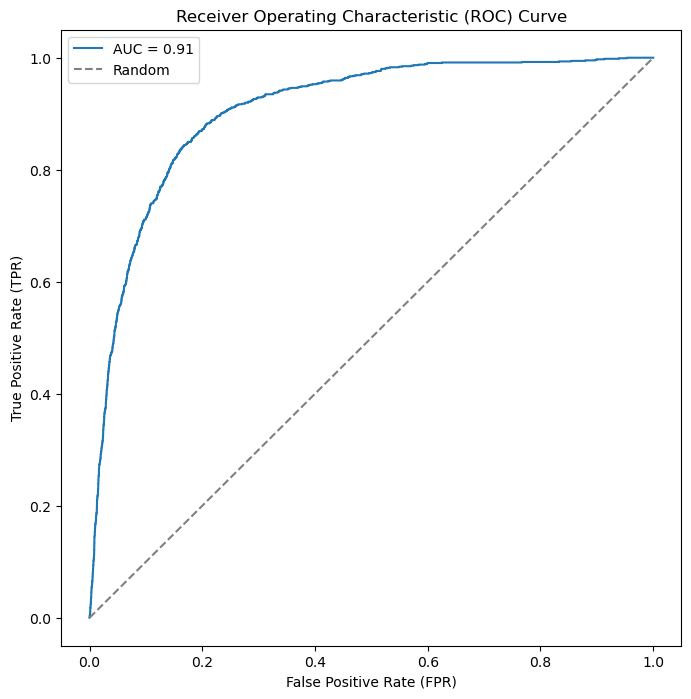


Model: Logistic Regression with L1 Regularization
Confusion Matrix:
 [[7783  202]
 [ 690  368]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.65      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



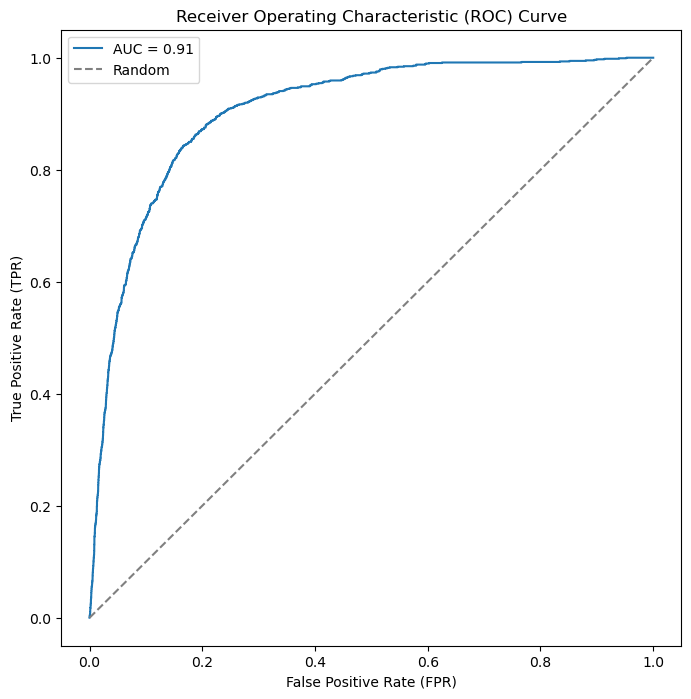


Model: Logistic Regression with L2 Regularization
Confusion Matrix:
 [[7783  202]
 [ 689  369]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.65      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



In [7]:
# Define the three logistic regression models
logistic_regression_models = {
    'Basic Logistic Regression': LogisticRegression(random_state=42, max_iter=300),
    'Logistic Regression with L1 Regularization': LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=300),
    'Logistic Regression with L2 Regularization': LogisticRegression(penalty='l2', random_state=42, max_iter=300),
}

# Create and evaluate each model
for model_name, model in logistic_regression_models.items():
    # Create a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Step 1: Get predicted probabilities for the positive class
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Step 2: Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Step 3: Compute Area Under the Curve (AUC)
    auc = roc_auc_score(y_test, y_prob)

    # Step 4: Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    plt.show()

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    print(f"\nModel: {model_name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))